# [ML2] Homework 1
LT5 - Castillo, Cruz, Madarang, Valera

In [1]:
!uv add scikit-learn==1.5.2

Resolved 54 packages in 4ms
Audited 21 packages in 0.11ms


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../../data/international-airline-passengers.csv")
df = df.iloc[:-1]
df.columns = ["month", "passengers_thousands"]

df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [4]:
df.dtypes

month                   datetime64[ns]
passengers_thousands           float64
dtype: object

In [5]:
print(df["month"].min())
print(df["month"].max())

1949-01-01 00:00:00
1960-12-01 00:00:00


In [6]:
df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


## Data Preparation

In [7]:
train_df = df[df["month"].dt.year<1960]
train_df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [8]:
val_df = df[df["month"].dt.year==1960]
val_df.head()

,month,passengers_thousands
132,1960-01-01,417.0
133,1960-02-01,391.0
134,1960-03-01,419.0
135,1960-04-01,461.0
136,1960-05-01,472.0


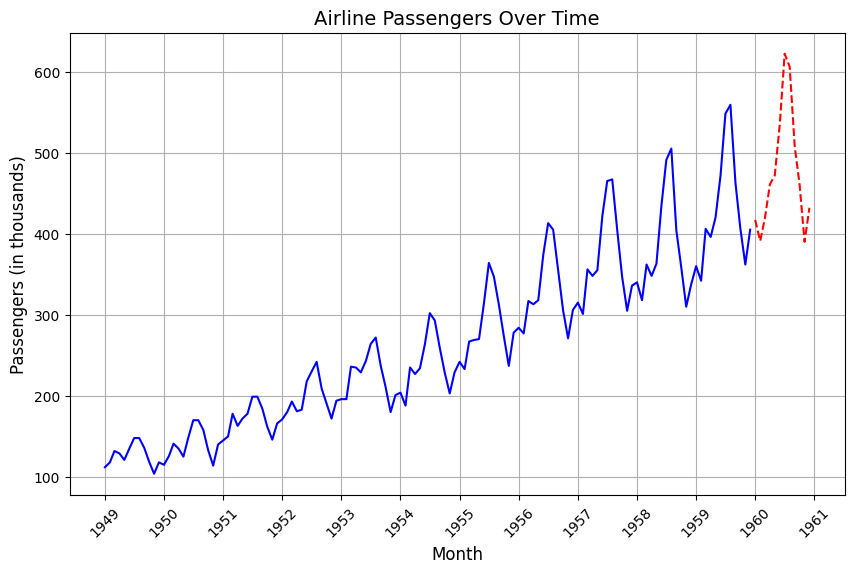

In [9]:
years = list(df["month"].dt.year.unique())
years.append(max(years) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_df["month"], train_df["passengers_thousands"], color="b")
plt.plot(val_df["month"], val_df["passengers_thousands"], color="r", linestyle="--")
plt.xticks(
    ticks=pd.to_datetime([f"{year}-01-01" for year in years]), 
    labels=years, 
    rotation=45  # Rotate for better readability if needed
)
plt.title("Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

### Create deseasonalized dataset

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

ADF Statistic: -3.048011
p-value: 0.030648
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


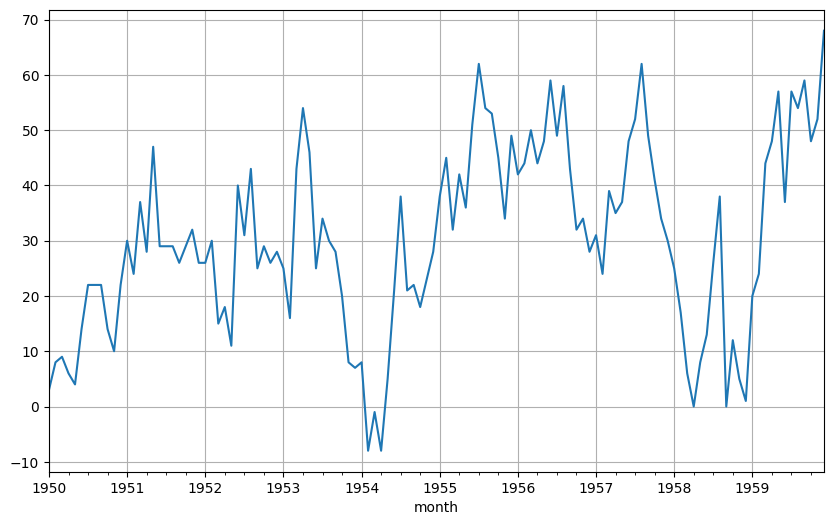

In [12]:
X = train_df["passengers_thousands"]
months_in_year = 12

stationary = difference(X, months_in_year)
stationary.index = train_df["month"][months_in_year:]

result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.figure(figsize=(10, 6))
stationary.plot()
plt.grid(True)
plt.show()

In [13]:
# result = adfuller(train_df["passengers_thousands"])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# #p < \alpha reject the null hypothesis (system has no unit root = stationary)
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

### Select lag values for AR and MA

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

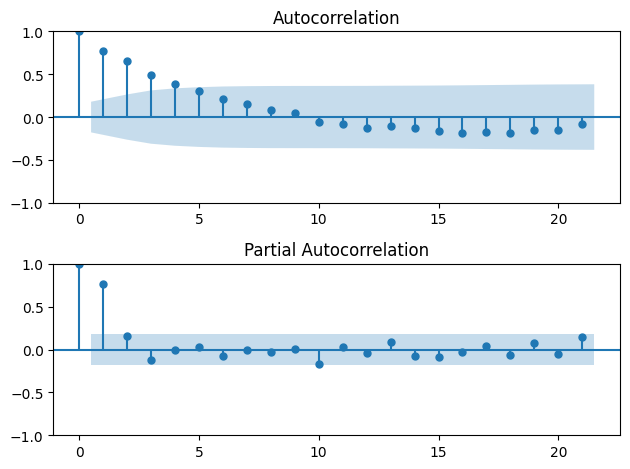

In [15]:
# Create a figure for subplots
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()

### ARIMA

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from itertools import product

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [17]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [18]:
X = train_df["passengers_thousands"]
X.index = train_df["month"]

X

month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
Name: passengers_thousands, Length: 132, dtype: float64

In [19]:
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

In [20]:
history = [x for x in train]
predictions = []
months_in_year = 12  # Seasonal differencing interval

for i in range(len(test)):
    # Difference the data
    diff = difference(history, months_in_year)
    
    # Fit ARIMA model
    model = ARIMA(diff, order=(1, 0, 1))
    model_fit = model.fit()
    
    # Forecast one step ahead
    forecast = model_fit.forecast(steps=1)
    
    # Reverse differencing
    yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
    predictions.append(yhat)
    
    # Observation
    obs = test[i]
    history.append(obs)
    print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')

>Predicted=353.660, Expected=347.000
>Predicted=311.477, Expected=305.000
>Predicted=340.272, Expected=336.000
>Predicted=345.464, Expected=340.000
>Predicted=327.320, Expected=318.000
>Predicted=375.937, Expected=362.000
>Predicted=358.871, Expected=348.000
>Predicted=359.968, Expected=363.000
>Predicted=432.321, Expected=435.000
>Predicted=479.728, Expected=491.000
>Predicted=492.110, Expected=505.000
>Predicted=439.347, Expected=404.000
>Predicted=355.913, Expected=359.000
>Predicted=318.925, Expected=310.000
>Predicted=345.515, Expected=337.000
>Predicted=345.817, Expected=360.000
>Predicted=336.981, Expected=342.000
>Predicted=385.796, Expected=406.000
>Predicted=386.824, Expected=396.000
>Predicted=406.648, Expected=420.000
>Predicted=485.980, Expected=472.000
>Predicted=527.893, Expected=548.000
>Predicted=554.873, Expected=559.000
>Predicted=453.576, Expected=463.000
>Predicted=412.330, Expected=407.000
>Predicted=355.854, Expected=362.000
>Predicted=384.864, Expected=405.000


RMSE: 12.662
MAE: 10.516


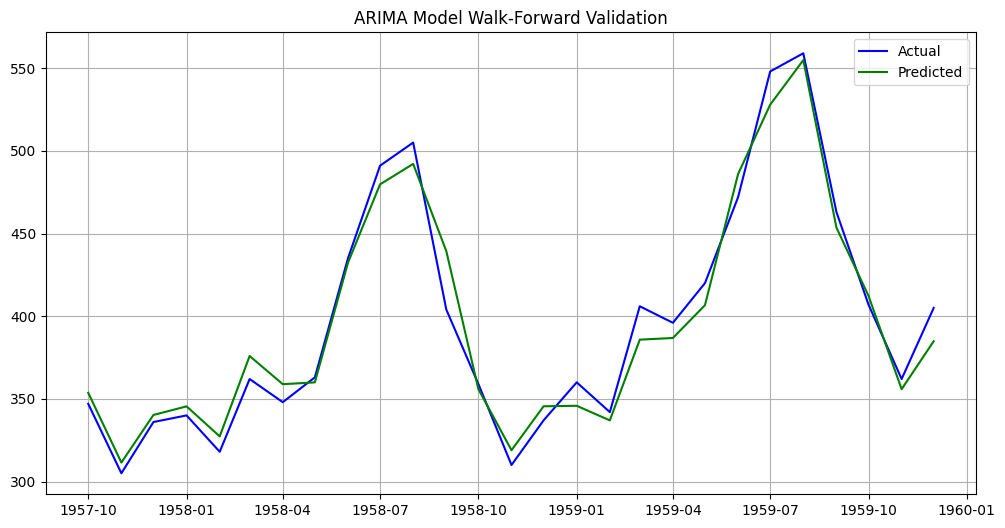

In [21]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", color="blue")
plt.plot(test.index, predictions, label="Predicted", color="green")
plt.title("ARIMA Model Walk-Forward Validation")
plt.legend()
plt.grid(True)
plt.show()

## (1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

In [22]:
def evaluate_arima_model(X, arima_order, return_preds=False, validation=False):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12

    predictions = []
    for t in range(len(test)):
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean.iloc[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    if return_preds:
        return test, predictions

    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

In [23]:
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

results = {}
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    rmse = evaluate_arima_model(X, order)
    results[order] = rmse
    print(f"Order {order}, RMSE: {rmse}")

Order (0, 0, 0), RMSE: 20.44119289127564
Order (0, 0, 1), RMSE: 16.03474448500369
Order (0, 0, 2), RMSE: 14.146867827658063
Order (0, 0, 3), RMSE: 12.892284121562017
Order (0, 1, 0), RMSE: 12.954335753515686
Order (0, 1, 1), RMSE: 12.940213948355337
Order (0, 1, 2), RMSE: 13.074519355605878
Order (0, 1, 3), RMSE: 12.957654464380385
Order (1, 0, 0), RMSE: 12.643366327399809
Order (1, 0, 1), RMSE: 12.66167884673632
Order (1, 0, 2), RMSE: 12.477491211313428
Order (1, 0, 3), RMSE: 12.657723174798011
Order (1, 1, 0), RMSE: 12.815013902663495
Order (1, 1, 1), RMSE: 12.776372248236495
Order (1, 1, 2), RMSE: 12.880998839651921
Order (1, 1, 3), RMSE: 13.105949625409803
Order (2, 0, 0), RMSE: 12.62485797946944
Order (2, 0, 1), RMSE: 12.741297543306105
Order (2, 0, 2), RMSE: 12.537240138889823
Order (2, 0, 3), RMSE: 12.65976803157613
Order (2, 1, 0), RMSE: 12.848654161798821
Order (2, 1, 1), RMSE: 12.865468703959962
Order (2, 1, 2), RMSE: 12.735547655764089
Order (2, 1, 3), RMSE: 13.2916906511538

In [24]:
best_order = min(results, key=results.get)
best_rmse = results[best_order]

print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")


Best Order: (1, 0, 2), Lowest RMSE: 12.477491211313428


               0
count  27.000000
mean    1.017615
std    12.672822
min   -38.197029
25%    -5.784506
50%     2.560830
75%     8.569044
max    23.457425


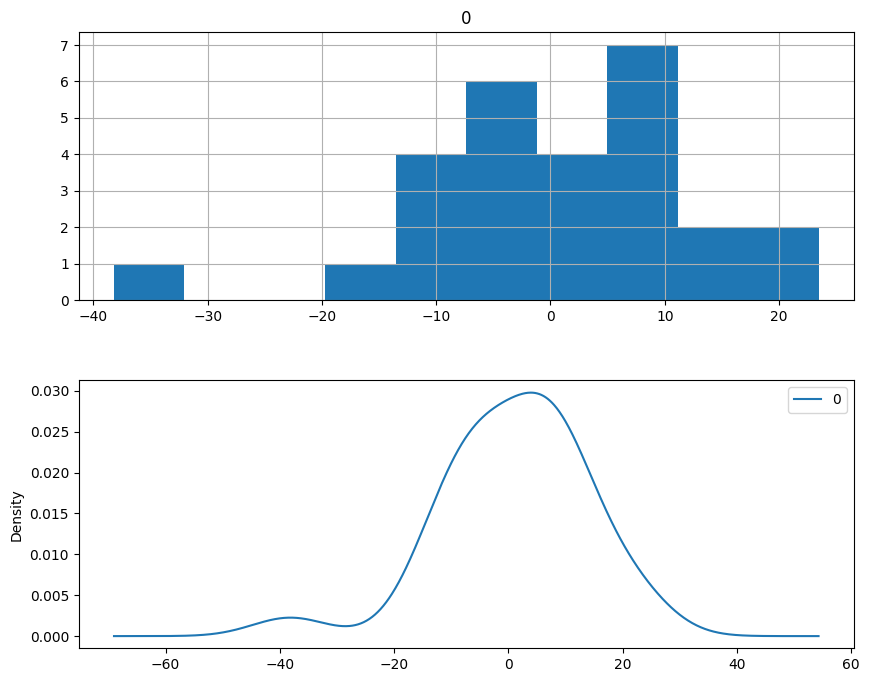

In [25]:
test, predictions = evaluate_arima_model(X, best_order, True)

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure(figsize=(10, 8))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind="kde", ax=plt.gca())
plt.show()

Mean is near zero. Should be fine.

### Validation

In [26]:
import time

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

In [27]:
val = val_df["passengers_thousands"]
val.index = val_df["month"]

In [28]:
len(val)

12

>Predicted=796.657, Expected=417.000
>Predicted=397.654, Expected=391.000
>Predicted=450.321, Expected=419.000
>Predicted=409.434, Expected=461.000
>Predicted=466.140, Expected=472.000
>Predicted=524.103, Expected=535.000
>Predicted=603.656, Expected=622.000
>Predicted=623.475, Expected=606.000
>Predicted=511.628, Expected=508.000
>Predicted=446.064, Expected=461.000
>Predicted=408.794, Expected=390.000
>Predicted=438.783, Expected=432.000
RMSE: 111.525
MAE: 47.160
Elapsed Time: 0.283


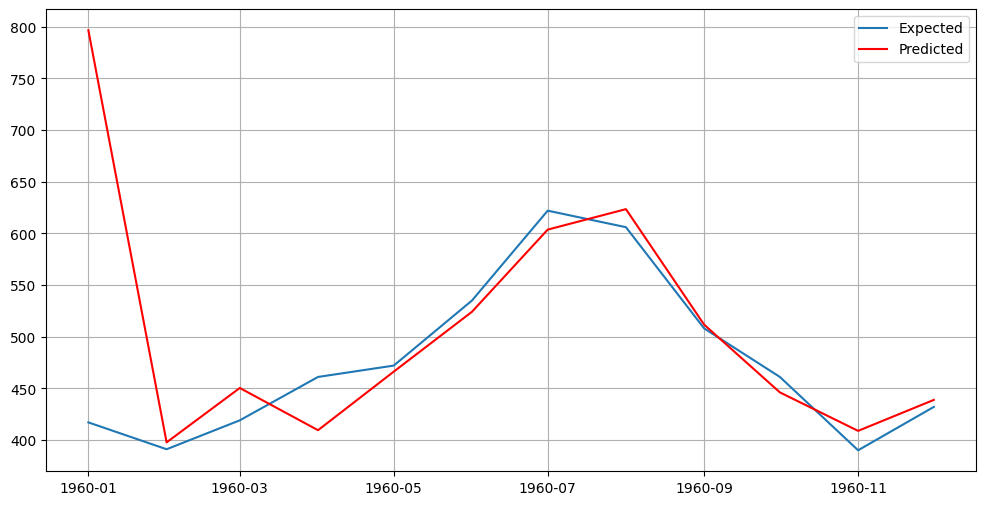

In [29]:
arima_results = {}

model = ARIMA(X, order=best_order)
model_fit = model.fit()

predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(val[0])
print(">Predicted=%.3f, Expected=%.3f" % (yhat, val[0]))

start_time = time.perf_counter()

for i in range(1, len(val)):
    # Difference the data
    diff = difference(history, months_in_year)
    # Fit the ARIMA model
    model = ARIMA(diff, order=best_order)
    model_fit = model.fit()
    # Forecast
    yhat = model_fit.forecast().iloc[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    obs = val[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

end_time = time.perf_counter()

# Report performance
mse = mean_squared_error(val, predictions)
rmse = sqrt(mse)
arima_results["rmse"] = rmse
print('RMSE: %.3f' % rmse)

mae = mean_absolute_error(val, predictions)
arima_results["mae"] = mae
print('MAE: %.3f' % mae)

total_time = end_time - start_time
arima_results["total_time"] = total_time
print("Elapsed Time: %.3f" % total_time)

predictions = pd.Series(predictions)
predictions.index = val.index

# Plot expected vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(val, label='Expected')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.grid(True)
plt.show()

## (2) Compare the results' RMSE, MAE, and run time with optimal XGBoost. [10 pts]

In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [31]:
df

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [32]:
new_train = df.set_index("month")
new_train

,passengers_thousands
month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [33]:
if not new_train.index.freq:
    new_train.index = pd.date_range(start=new_train.index[0], periods=len(new_train), freq="MS")

forecast_horizon = 12

def create_features(df, label=None):
    df["date"] = df.index
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    X = df[["year", "month", "dayofyear", "dayofweek", "quarter"]]
    if label:
        y = df[label]
        return X, y
    return X

train_size = len(new_train) - forecast_horizon
train, forecast_period = new_train[:train_size], new_train[train_size:]

X_train, y_train = create_features(new_train, label="passengers_thousands")
X_forecast = create_features(forecast_period)

In [34]:
# Define the XGBRegressor with fixed parameters
xgb_model = XGBRegressor()

# Fit the model to the training data
try:
    xgb_model.fit(X_train, y_train)
except Exception as e:
    print("Error during model fitting:", e)
    raise

# Forecast the next 12 months

try:
    xgboost_forecast = xgb_model.predict(X_forecast[:forecast_horizon])
    print("Forecast:", xgboost_forecast)
except Exception as e:
    print("Error during forecasting:", e)
    raise


Forecast: [416.99805 390.9991  418.99628 460.9987  472.00055 535.0041  621.99207
 606.0024  507.99857 460.99844 390.00122 432.00436]


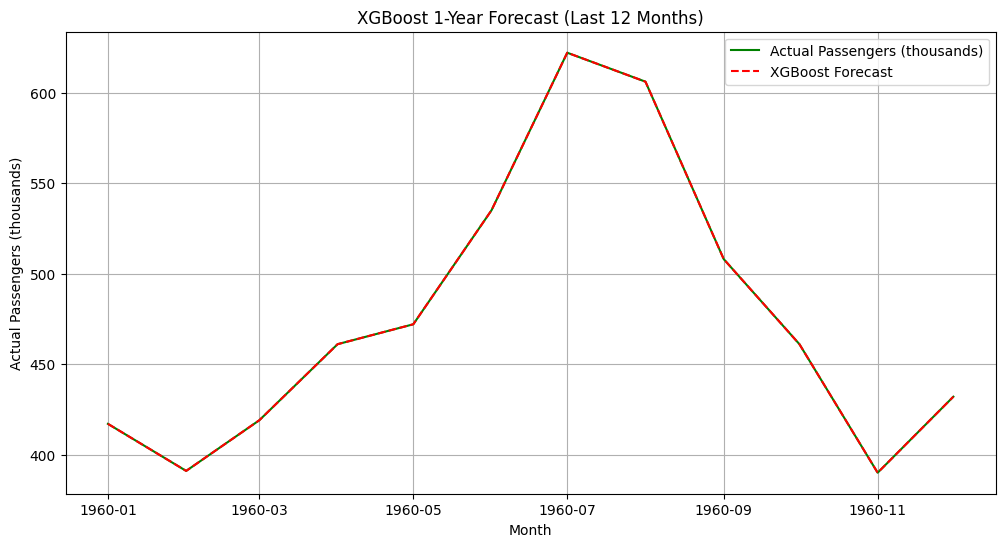

RMSE for XGBoost 1-Year Forecast: 0.0033020738745452635
MAE for XGBoost 1-Year Forecast: 0.00261688232421875


In [35]:
# Plot the forecast results for the test set (actual sales vs. forecast)
plt.figure(figsize=(12, 6))

# Plot the actual sales data for the forecast period (last 12 months) in green.
plt.plot(forecast_period.index[:forecast_horizon], forecast_period["passengers_thousands"][:forecast_horizon], label="Actual Passengers (thousands)", color="green")

# Plot the XGBoost forecasted sales data for the same 12-month period in red with a dashed line.
plt.plot(forecast_period.index[:forecast_horizon], xgboost_forecast, label="XGBoost Forecast", linestyle="--", color="red")

# Set the x-axis label to "Date" and the y-axis label to "Sales".
plt.xlabel("Month")
plt.ylabel("Actual Passengers (thousands)")

# Add a plot title, mentioning the XGBoost forecast for the last 12 months and showing the best parameters used in the model.
plt.title(f"XGBoost 1-Year Forecast (Last 12 Months)")

# Add a legend to differentiate between actual sales and forecasted sales.
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE & MAE
rmse = np.sqrt(mean_squared_error(forecast_period["passengers_thousands"][:forecast_horizon], xgboost_forecast))
print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")

mae = mean_absolute_error(forecast_period["passengers_thousands"][:forecast_horizon], xgboost_forecast)
print(f"MAE for XGBoost 1-Year Forecast: {mae}")


In [36]:
xgb_results = {}

param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8]
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Set up a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with the XGBRegressor and the parameter grid
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

# Perform grid search
try:
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)
except Exception as e:
    print("Error during grid search:", e)
    raise

# Use the best estimator for forecasting
best_model = grid_search.best_estimator_

# Forecast the next 12 months
start_time = time.perf_counter()
try:
    xgboost_forecast = best_model.predict(X_forecast[:forecast_horizon])
    print("Forecast:", xgboost_forecast)
except Exception as e:
    print("Error during forecasting:", e)
    raise
end_time = time.perf_counter()

rmse = np.sqrt(mean_squared_error(forecast_period["passengers_thousands"][:forecast_horizon], xgboost_forecast))
mae = mean_absolute_error(forecast_period["passengers_thousands"][:forecast_horizon], xgboost_forecast)

xgb_results["rmse"] = rmse
xgb_results["mae"] = mae
xgb_results["total_time"] = end_time - start_time

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Best Score: 3677.0002348207927
Forecast: [416.45383 389.18692 420.58777 457.7716  471.59158 536.02405 623.7351
 602.3275  512.48224 459.1362  392.26093 433.49933]


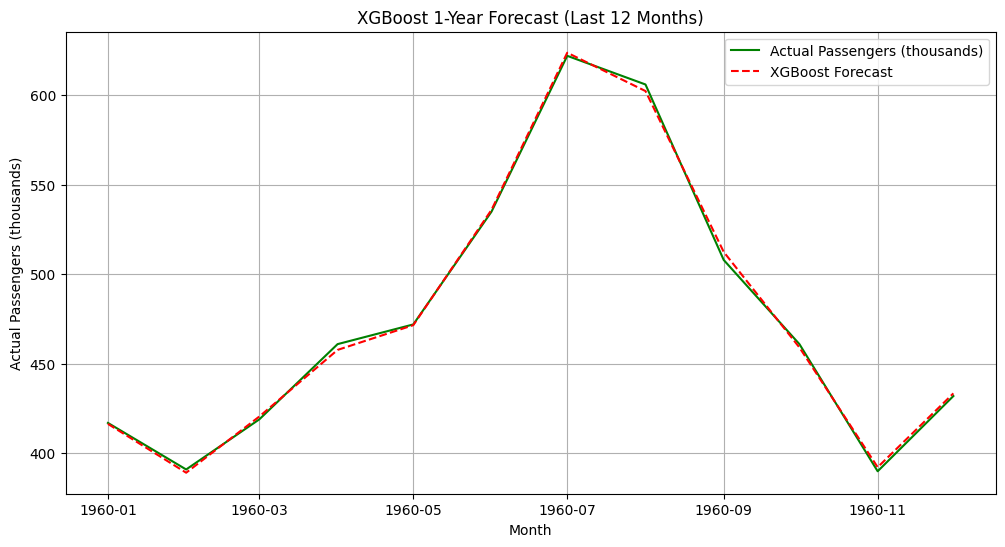

RMSE for XGBoost 1-Year Forecast: 2.3303488044966074
MAE for XGBoost 1-Year Forecast: 2.0101470947265625


In [37]:
# Plot the forecast results for the test set (actual sales vs. forecast)
plt.figure(figsize=(12, 6))

# Plot the actual sales data for the forecast period (last 12 months) in green.
plt.plot(forecast_period.index[:forecast_horizon], forecast_period["passengers_thousands"][:forecast_horizon], label="Actual Passengers (thousands)", color="green")

# Plot the XGBoost forecasted sales data for the same 12-month period in red with a dashed line.
plt.plot(forecast_period.index[:forecast_horizon], xgboost_forecast, label="XGBoost Forecast", linestyle="--", color="red")

# Set the x-axis label to "Date" and the y-axis label to "Sales".
plt.xlabel("Month")
plt.ylabel("Actual Passengers (thousands)")

# Add a plot title, mentioning the XGBoost forecast for the last 12 months and showing the best parameters used in the model.
plt.title(f"XGBoost 1-Year Forecast (Last 12 Months)")

# Add a legend to differentiate between actual sales and forecasted sales.
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE & MAE
print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")
print(f"MAE for XGBoost 1-Year Forecast: {mae}")

### Table Comparison

In [38]:
arima_results

{'rmse': 111.52513599516259,
 'mae': np.float64(47.159673701955846),
 'total_time': 0.28311945799941896}

In [39]:
xgb_results

{'rmse': np.float64(2.3303488044966074),
 'mae': np.float64(2.0101470947265625),
 'total_time': 0.0018217090037069283}

In [41]:
df_results = pd.DataFrame({
    "ARIMA": arima_results,
    "XGB": xgb_results
})

df_results = df_results.round(3)
df_results

,ARIMA,XGB
rmse,111.525,2.330
mae,47.160,2.010
total_time,0.283,0.002
